# Code For Cybersecurity Policies Analysis Model
### **Note:** In order to successfully run code, file path directories must be altered depending on platform used and file paths on personal computer.

### Data required for this code can be found here: https://figshare.com/articles/dataset/Natural_Language_Understanding_Dataset_for_DoD_Cybersecurity_Policies_CSIAC-DoDIN_V1_0_/22800185/1

#### Contributors: Elijah Ritchie, Noah Choate, Cole Caldwell, Giana Grace, Ahil Jamal, Zhizhong Liu

In [2]:
!pip install datasets
!pip install -U transformers
!pip install evaluate

## Loading the Data
Google colab is ideal for using this code. Create a folder for the data and
Cybersecurity-Policies-Analysis.ipynb


After this alter the file path according to the path you are using >> Specifically on the pd.read_csv command

In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Load your dataset
original_df = pd.read_csv('/content/drive/My Drive/ColabNotebooks/DSC4310/Data/dataset.csv')

# Drop rows with missing Classification
df = original_df.dropna(subset=['Classification'])

print("Number of samples:", len(df))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of samples: 6160


In [4]:
df.head()

,Id,Cluster,Classification,Source,Purpose,Scope and Application,Type,Text
1538,DoDI 8410.02 NetOps for the Global Information...,Prepare,Sustain Missions,DOD CIO,In accordance with the authority in DoD Direct...,"OSD, the Military Departments (including the C...",Policy,DODIN operations will be instituted and conduc...
1539,DoDI 8410.02 NetOps for the Global Information...,Prepare,Sustain Missions,DOD CIO,In accordance with the authority in DoD Direct...,"OSD, the Military Departments (including the C...",Policy,DODIN operations are the responsibility of all...
1540,DoDI 8410.02 NetOps for the Global Information...,Prepare,Sustain Missions,DOD CIO,In accordance with the authority in DoD Direct...,"OSD, the Military Departments (including the C...",Policy,DODIN operations will be operationally and tec...
1541,DoDI 8410.02 NetOps for the Global Information...,Prepare,Sustain Missions,DOD CIO,In accordance with the authority in DoD Direct...,"OSD, the Military Departments (including the C...",Policy,Risk decisions affecting DODIN operations must...
1542,DoDI 8410.02 NetOps for the Global Information...,Prepare,Sustain Missions,DOD CIO,In accordance with the authority in DoD Direct...,"OSD, the Military Departments (including the C...",Policy,"DoD IS, DODIN-connected NSS, and DODIN-connect..."


In [5]:
!pip install datasets

In [6]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'].tolist(),
    df['Classification'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['Classification']
)

# Create Huggingface Dataset objects
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})

# Label Encoding
unique_labels = sorted(list(set(train_labels + val_labels)))
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

train_dataset = train_dataset.map(lambda e: {'label': label2id[e['label']]})
val_dataset = val_dataset.map(lambda e: {'label': label2id[e['label']]})

print(label2id)


Map:   0%|          | 0/4928 [00:00<?, ? examples/s]

Map:   0%|          | 0/1232 [00:00<?, ? examples/s]

{'Assure Information Sharing': 0, 'Design for the Fight': 1, 'Develop and Maintain Trust': 2, 'Develop the Workforce': 3, 'Develop the Workforce ': 4, 'Manage Access': 5, 'Partner for Strength': 6, 'Prevent and Delay Attackers and Prevent Attackers from Staying': 7, 'Secure Data in Transit': 8, 'Strengthen Cyber Readiness': 9, 'Sustain Missions': 10, 'Understand the Battlespace': 11}


In [7]:
# Implement class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute balanced class weights on the TRAIN labels
classes = np.unique(train_labels)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)


Class weights: {np.str_('Assure Information Sharing'): np.float64(0.5687903970452447), np.str_('Design for the Fight'): np.float64(0.5120532003325021), np.str_('Develop and Maintain Trust'): np.float64(12.07843137254902), np.str_('Develop the Workforce'): np.float64(5.264957264957265), np.str_('Develop the Workforce '): np.float64(58.666666666666664), np.str_('Manage Access'): np.float64(0.628892291985707), np.str_('Partner for Strength'): np.float64(5.008130081300813), np.str_('Prevent and Delay Attackers and Prevent Attackers from Staying'): np.float64(0.23710546574287913), np.str_('Secure Data in Transit'): np.float64(0.7748427672955975), np.str_('Strengthen Cyber Readiness'): np.float64(3.393939393939394), np.str_('Sustain Missions'): np.float64(4.562962962962963), np.str_('Understand the Battlespace'): np.float64(5.333333333333333)}


In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the base model checkpoint to load from Hugging Face
model_checkpoint = "sentence-transformers/paraphrase-MiniLM-L6-v2"

# Load tokenizer for the chosen model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Load pre-trained model and configure it for classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Tokenize the text field in batches, applying padding and truncation
def tokenize_function(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=512)

# Apply tokenization to both train and validation datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set dataset format for PyTorch training
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Map:   0%|          | 0/4928 [00:00<?, ? examples/s]

Map:   0%|          | 0/1232 [00:00<?, ? examples/s]

In [10]:
!pip install evaluate

In [16]:
from transformers import TrainingArguments, Trainer
import evaluate
import torch
import torch.nn as nn

# !!! Important !!!
# When code is run, it will prompt for an API key
# API Key needed to run the model: 42a83ecaac9134fb2a23a96d407d5c37100c727a
# Just copy and paste it in the box and press enter

# Load the accuracy metric from Hugging Face evaluate library
metric = evaluate.load('accuracy')

# Function to compute evaluation metrics (only accuracy)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./sbert-classification",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
)

# Subclass Trainer to inject class-weights
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        num_labels = self.model.config.num_labels
        weight_list = [class_weights.get(i, 1.0) for i in range(num_labels)]
        self.class_weights = torch.tensor(weight_list, dtype=torch.float).to(self.model.device)

    # Accept and ignore any extra kwargs (e.g., num_items_in_batch)
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

# Instantiate our weighted trainer
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


Step,Training Loss
100,1.668600
200,1.415100
300,1.208300
400,1.056700
500,0.921100
600,0.819500
700,0.699500
800,0.667500
900,0.632400
1000,0.558900


TrainOutput(global_step=1540, training_loss=0.7975541312973221, metrics={'train_runtime': 419.5878, 'train_samples_per_second': 58.724, 'train_steps_per_second': 3.67, 'total_flos': 817496972328960.0, 'train_loss': 0.7975541312973221, 'epoch': 5.0})

In [17]:
# Print metrics
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.5453446507453918, 'eval_accuracy': 0.8587662337662337, 'eval_runtime': 6.3778, 'eval_samples_per_second': 193.171, 'eval_steps_per_second': 12.073, 'epoch': 5.0}


In [18]:
model.save_pretrained('/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final')
tokenizer.save_pretrained('/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final')


('/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final/tokenizer_config.json',
 '/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final/special_tokens_map.json',
 '/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final/vocab.txt',
 '/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final/added_tokens.json',
 '/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final/tokenizer.json')

In [19]:
from sklearn.metrics import classification_report

# Predict and print classification report
preds = trainer.predict(val_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=list(id2label.values())))

# We can see that the classifications drop from the over-sampled Classifications, and rise for the under-sampled classifications,
# After comparing the two, we decided to keep the version without Class weights. There is no large difference
# Realistically, it may be a net-positive for our model to certain for the larger classifications, and implement
# Human review for the smaller classifications with ~10 - 20 documents in a real workplace scenario.

                                                                precision    recall  f1-score   support

                                    Assure Information Sharing       0.88      0.94      0.91       181
                                          Design for the Fight       0.84      0.91      0.87       200
                                    Develop and Maintain Trust       0.00      0.00      0.00         9
                                         Develop the Workforce       0.69      0.55      0.61        20
                                        Develop the Workforce        0.00      0.00      0.00         2
                                                 Manage Access       0.81      0.89      0.85       163
                                          Partner for Strength       0.50      0.05      0.09        20
Prevent and Delay Attackers and Prevent Attackers from Staying       0.93      0.97      0.95       433
                                        Secure Data in Transit 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions from the trainer
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

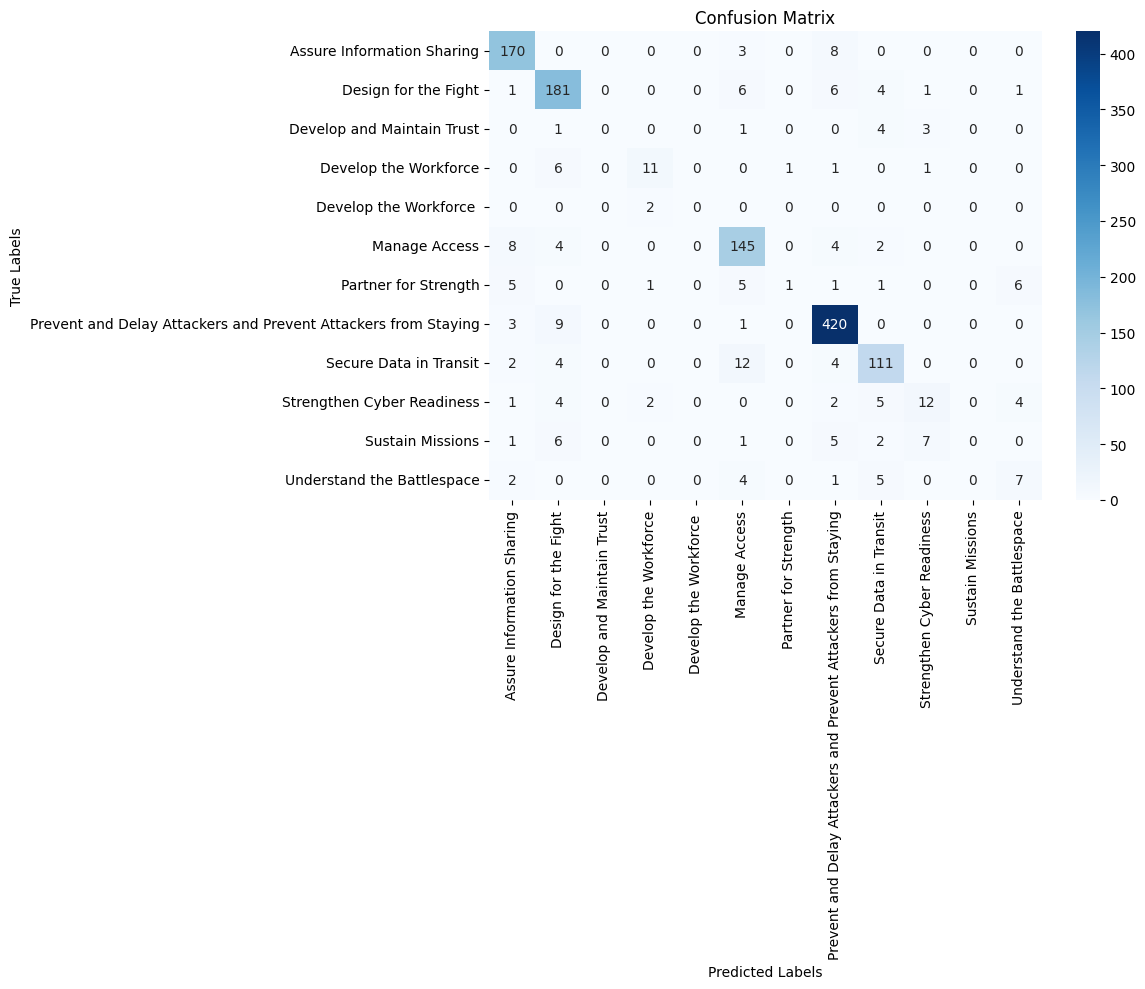

In [21]:
# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

In [23]:
from transformers import AutoModel, AutoTokenizer
import torch

# Load fine-tuned encoder
encoder_model = AutoModel.from_pretrained(
    '/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final',
    local_files_only=True
)
encoder_tokenizer = AutoTokenizer.from_pretrained(
    '/content/drive/My Drive/ColabNotebooks/DSC4310/FinalProject/fine_tuned_sbert_model_final',
    local_files_only=True
)

# Set model to eval mode
encoder_model.eval()

# Function to encode texts
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = encoder_tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
            outputs = encoder_model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(embeddings.cpu())
    return torch.cat(all_embeddings, dim=0)

# Generate embeddings
texts = df['Text'].tolist()
embeddings = get_embeddings(texts)
print(embeddings.shape)  # (6160, 384)


torch.Size([6160, 384])


In [24]:
from sklearn.cluster import KMeans

# Choose number of clusters
n_clusters = 8  # you can tune

# Apply KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings.numpy())

# Save cluster labels into your DataFrame
df['cluster_id'] = cluster_labels


<ipython-input-24-179f66c4938c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_id'] = cluster_labels


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


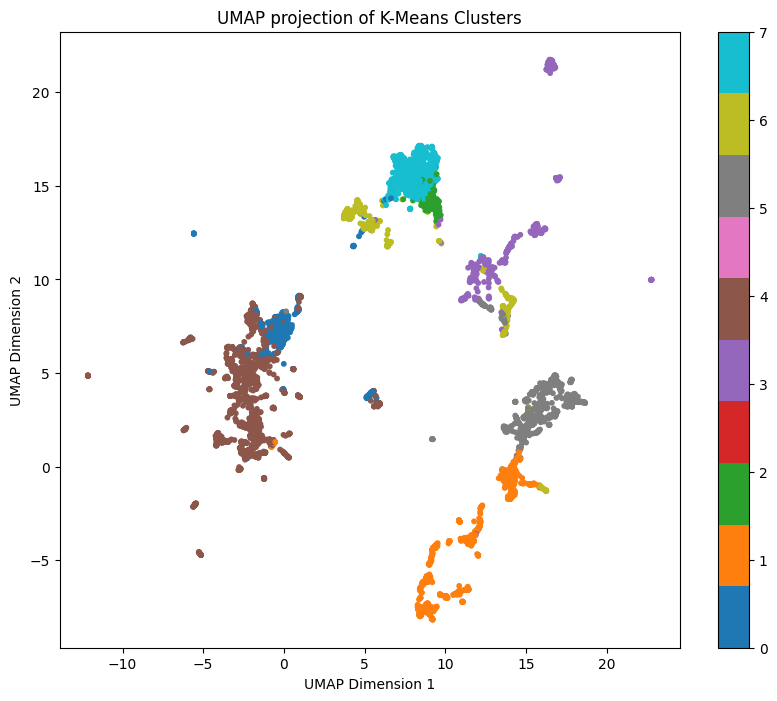

In [25]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# UMAP projection
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings.numpy())

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.colorbar(scatter)
plt.title('UMAP projection of K-Means Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.savefig('umap_plot.png')
plt.show()


In [26]:
from sklearn.metrics import silhouette_score

# Evaluate clustering performance
score = silhouette_score(embeddings.numpy(), cluster_labels)
print(f"Silhouette Score for KMeans clustering: {score:.4f}")


Silhouette Score for KMeans clustering: 0.4170


<ipython-input-27-df1922667e72>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TSNE1'] = tsne_proj[:, 0]
<ipython-input-27-df1922667e72>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TSNE2'] = tsne_proj[:, 1]


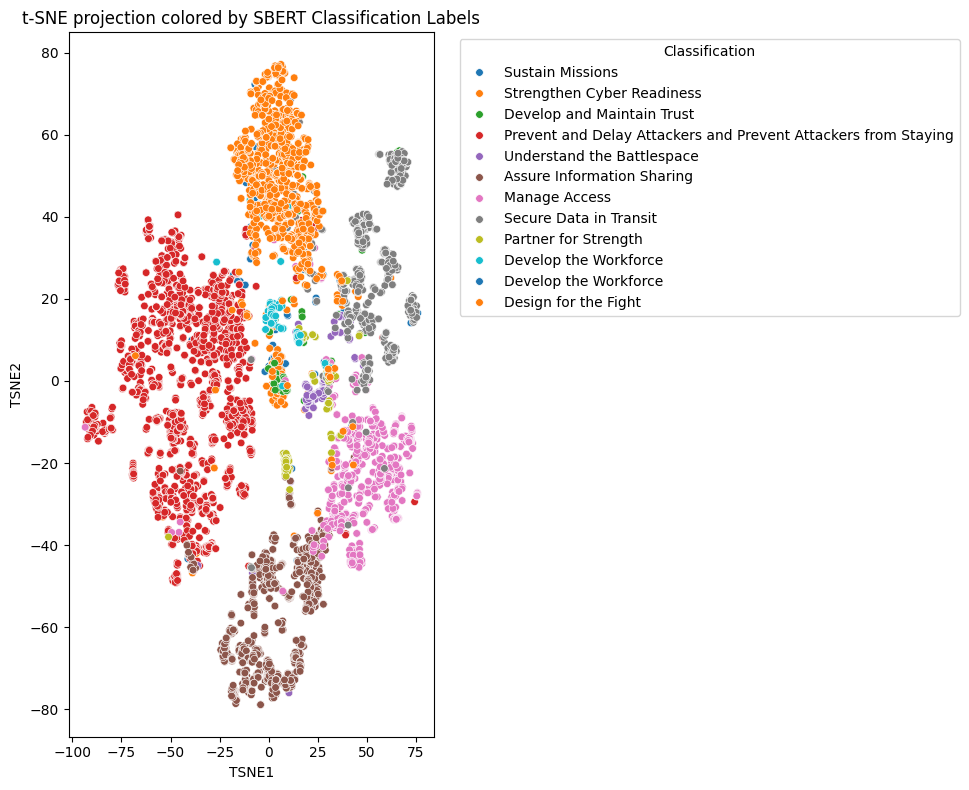

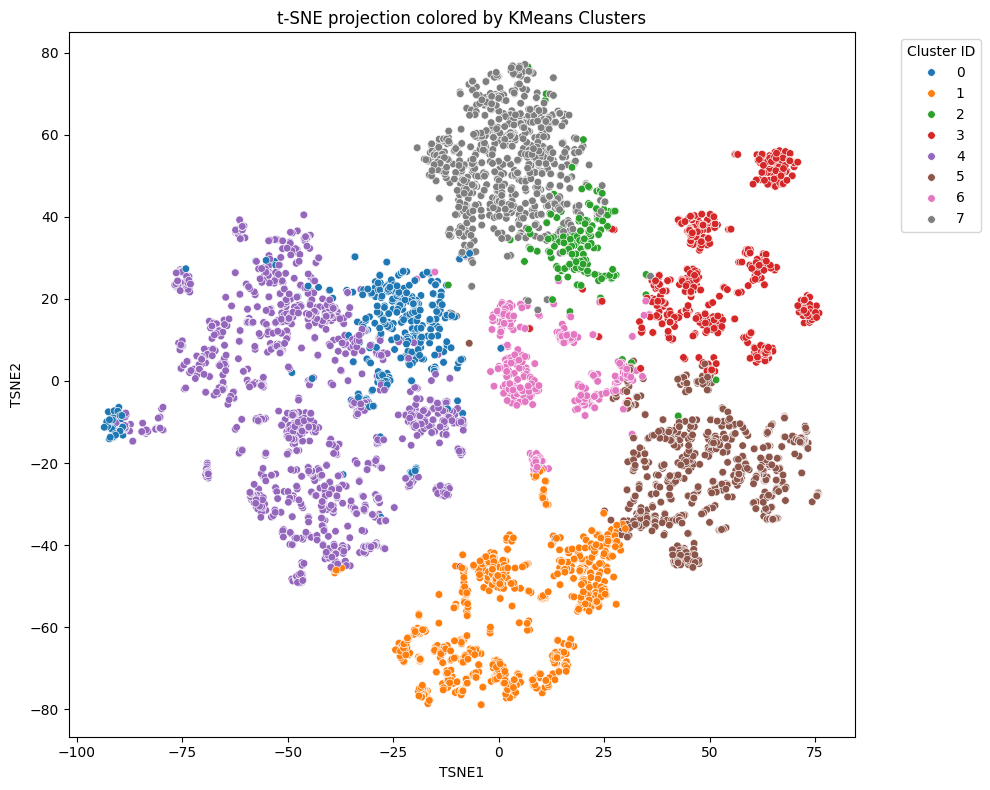

In [27]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `embeddings` contains your SBERT (6160, 384) embeddings
# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_proj = tsne.fit_transform(embeddings.numpy())

# Add t-SNE components to the DataFrame
df['TSNE1'] = tsne_proj[:, 0]
df['TSNE2'] = tsne_proj[:, 1]

# Plot t-SNE by SBERT classifications
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Classification', palette='tab10', s=30)
plt.title('t-SNE projection colored by SBERT Classification Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Classification')
plt.tight_layout()
plt.show()

#  Plot t-SNE by KMeans Cluster IDs
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='cluster_id', palette='tab10', s=30)
plt.title('t-SNE projection colored by KMeans Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster ID')
plt.tight_layout()
plt.show()



In [28]:
import shap
import torch
from transformers import pipeline
import os
import webbrowser

# Initialize JS for SHAP visualizations
shap.initjs()

# Put model in eval mode
model.eval()

# Create the classification pipeline
pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=encoder_tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Create masker and explainer
masker = shap.maskers.Text(tokenizer=encoder_tokenizer)
explainer = shap.Explainer(pipe, masker)

# Sample texts from dataframe
sample_texts = df['Text'].sample(5, random_state=42).tolist()

# Compute SHAP values
shap_values = explainer(sample_texts)

# Initialize the HTML content
combined_html = "<html><head><title>SHAP Explanations</title></head><body>"

# Loop through each explanation and add it to html file
for i, shap_val in enumerate(shap_values):
    combined_html += f"<h2>SHAP explanation for sample #{i+1}</h2>"
    html_content = shap.plots.text(shap_val, display=False)
    combined_html += html_content  # Add the HTML content for each explanation

combined_html += "</body></html>"

# Save HTML file
output_file = "shap_explanations_combined.html"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(combined_html)


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 6it [00:20,  6.94s/it]


In [29]:
# Download html file with SHAP explanations
from google.colab import files
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>